### Import packages

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegressionCV

import stellargraph as sg
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN, GAT
from stellargraph import globalvar

from tensorflow.keras import layers, optimizers, losses, metrics, Model, models
from sklearn import preprocessing, feature_extraction
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


### Load the dataset

In [122]:
df = pd.read_csv(r'cell2celltrain.csv').head(500).dropna().copy()
df.shape

(485, 58)

In [123]:
df.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber,IncomeGroup,OwnsMotorcycle,AdjustmentsToCreditRating,HandsetPrice,MadeCallToRetentionTeam,CreditRating,PrizmCode,Occupation,MaritalStatus
0,3000002,Yes,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,4,No,0,30,Yes,1-Highest,Suburban,Professional,No
1,3000010,Yes,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,5,No,0,30,No,4-Medium,Suburban,Professional,Yes
2,3000014,No,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,6,No,0,Unknown,No,3-Good,Town,Crafts,Yes
3,3000022,No,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,6,No,0,10,No,4-Medium,Other,Other,No
4,3000026,Yes,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,9,No,1,10,No,1-Highest,Other,Professional,Yes


In [124]:
df.Churn[df.Churn =='Yes'] = int(1)
df.Churn[df.Churn =='No'] = int(0)
df["Churn"] = df["Churn"].astype(int)

columns_list = df.columns
print(columns_list)
cat_cols = []
num_cols = []
for i,col in enumerate(columns_list):
    if(df[col].dtypes == 'object'):
        cat_cols.append(col)
    else:
        num_cols.append(col)
print(len(num_cols), num_cols)
print("\n")
print(len(cat_cols), cat_cols)

Index(['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes',
       'TotalRecurringCharge', 'DirectorAssistedCalls', 'OverageMinutes',
       'RoamingCalls', 'PercChangeMinutes', 'PercChangeRevenues',
       'DroppedCalls', 'BlockedCalls', 'UnansweredCalls', 'CustomerCareCalls',
       'ThreewayCalls', 'ReceivedCalls', 'OutboundCalls', 'InboundCalls',
       'PeakCallsInOut', 'OffPeakCallsInOut', 'DroppedBlockedCalls',
       'CallForwardingCalls', 'CallWaitingCalls', 'MonthsInService',
       'UniqueSubs', 'ActiveSubs', 'ServiceArea', 'Handsets', 'HandsetModels',
       'CurrentEquipmentDays', 'AgeHH1', 'AgeHH2', 'ChildrenInHH',
       'HandsetRefurbished', 'HandsetWebCapable', 'TruckOwner', 'RVOwner',
       'Homeownership', 'BuysViaMailOrder', 'RespondsToMailOffers',
       'OptOutMailings', 'NonUSTravel', 'OwnsComputer', 'HasCreditCard',
       'RetentionCalls', 'RetentionOffersAccepted', 'NewCellphoneUser',
       'NotNewCellphoneUser', 'ReferralsMadeBySubscriber', 'IncomeGro

C:\Users\Sandeep\Anaconda3\envs\dl_ver\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Sandeep\Anaconda3\envs\dl_ver\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
df.dtypes

CustomerID                     int64
Churn                          int32
MonthlyRevenue               float64
MonthlyMinutes               float64
TotalRecurringCharge         float64
DirectorAssistedCalls        float64
OverageMinutes               float64
RoamingCalls                 float64
PercChangeMinutes            float64
PercChangeRevenues           float64
DroppedCalls                 float64
BlockedCalls                 float64
UnansweredCalls              float64
CustomerCareCalls            float64
ThreewayCalls                float64
ReceivedCalls                float64
OutboundCalls                float64
InboundCalls                 float64
PeakCallsInOut               float64
OffPeakCallsInOut            float64
DroppedBlockedCalls          float64
CallForwardingCalls          float64
CallWaitingCalls             float64
MonthsInService                int64
UniqueSubs                     int64
ActiveSubs                     int64
ServiceArea                   object
H

### Utilities function for graph, preprocessing and cleaning

In [126]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

def prepare_eadge_dataset(input_dataset, column_ID, column_edge):
    data_to_merge = input_dataset[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() # select columns, remove NaN

    # To create connections between people who have the same number,
    # join data with itself on the 'ID' column.
    data_to_merge = data_to_merge.merge(
        data_to_merge[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}), 
        on=column_edge
    )
    
    # By joining the data with itself, people will have a connection with themselves.
    # Remove self connections, to keep only connected people who are different.
    d = data_to_merge[~(data_to_merge[column_ID]==data_to_merge[column_ID+"_2"])].dropna()[[column_ID, column_ID+"_2", column_edge]]

    # To avoid counting twice the connections (person 1 connected to person 2 and person 2 connected to person 1)
    # we force the first ID to be "lower" then ID_2
    d.drop(d.loc[d[column_ID+"_2"]<d[column_ID]].index.tolist(), inplace=True)
    
    d = d.drop(column_edge, axis=1)
    return d


def preprocess_features(input_dataset):
    #input_dataset['HandsetPrice'] = input_dataset['HandsetPrice'].replace(to_replace = 'Unknown', value = 0, inplace=True)
    #input_dataset = input_dataset.drop('HandsetPrice', axis=1)
    #customer id col
    Id_col     = ['CustomerID']
    #Target columns
    target_col = ["Churn"]
    #categorical columns
    cat_cols   = input_dataset.nunique()[input_dataset.nunique() < 10].keys().tolist()
    cat_cols   = [x for x in cat_cols if x not in target_col]
    #numerical columns
    num_cols   = [x for x in input_dataset.columns if x not in cat_cols + target_col + Id_col]
    #Binary columns with 2 values
    bin_cols   = input_dataset.nunique()[input_dataset.nunique() == 2].keys().tolist()
    #Columns more than 2 values
    multi_cols = [i for i in cat_cols if i not in bin_cols]

    #Label encoding Binary columns
    le = LabelEncoder()
    for i in bin_cols :
        input_dataset[i] = le.fit_transform(input_dataset[i])

    #Duplicating columns for multi value columns
    input_dataset = pd.get_dummies(data = input_dataset,columns = multi_cols )
    """
    #Scaling Numerical columns
    std = StandardScaler()
    scaled = std.fit_transform(input_dataset[num_cols])
    scaled = pd.DataFrame(scaled,columns=num_cols)

    #dropping original values merging scaled values for numerical columns
    input_dataset = input_dataset.drop(columns = num_cols,axis = 1)
    input_dataset = input_dataset.merge(scaled,left_index=True,right_index=True,how = "left")
    """
    return input_dataset

### Prepare and load Graph

In [127]:
column_edge_list = ['ServiceArea', 'MaritalStatus', 'Occupation']
feature_columns_list = list(set(df.columns)-set(column_edge_list))
print(len(feature_columns_list))
print(feature_columns_list)

55
['CustomerID', 'UnansweredCalls', 'PeakCallsInOut', 'HandsetPrice', 'DirectorAssistedCalls', 'RoamingCalls', 'HandsetWebCapable', 'MonthsInService', 'AgeHH1', 'AgeHH2', 'OwnsComputer', 'RetentionCalls', 'NonUSTravel', 'IncomeGroup', 'PercChangeMinutes', 'HasCreditCard', 'ThreewayCalls', 'RetentionOffersAccepted', 'CurrentEquipmentDays', 'Handsets', 'TruckOwner', 'MonthlyMinutes', 'Homeownership', 'OutboundCalls', 'ReceivedCalls', 'HandsetModels', 'OptOutMailings', 'RVOwner', 'ChildrenInHH', 'PercChangeRevenues', 'MadeCallToRetentionTeam', 'BuysViaMailOrder', 'ActiveSubs', 'NewCellphoneUser', 'TotalRecurringCharge', 'InboundCalls', 'MonthlyRevenue', 'UniqueSubs', 'CallWaitingCalls', 'RespondsToMailOffers', 'CallForwardingCalls', 'CustomerCareCalls', 'Churn', 'CreditRating', 'HandsetRefurbished', 'BlockedCalls', 'NotNewCellphoneUser', 'OwnsMotorcycle', 'OverageMinutes', 'OffPeakCallsInOut', 'ReferralsMadeBySubscriber', 'DroppedCalls', 'AdjustmentsToCreditRating', 'PrizmCode', 'Dropped

In [128]:
edge_df = df[['CustomerID']+column_edge_list]
edge_df.shape

(485, 4)

In [129]:
all_node_edge_df = pd.DataFrame(columns=['CustomerID', 'CustomerID_2'])
column_ID = 'CustomerID'
column_edge_list = column_edge_list
for column_edge in column_edge_list:
    node_edge_df = prepare_eadge_dataset(edge_df, column_ID, column_edge)
    print(node_edge_df.shape)
    all_node_edge_df = all_node_edge_df.append(node_edge_df, ignore_index=True)
all_node_edge_df.shape

(3194, 2)
(40939, 2)
(57654, 2)


(101787, 2)

In [130]:
all_node_edge_df = all_node_edge_df.drop_duplicates()
print(all_node_edge_df.shape)
all_node_edge_df.head()

(79136, 2)


,CustomerID,CustomerID_2
0,3000002,3000982
1,3000002,3001426
2,3000002,3001454
3,3000002,3002070
4,3000002,3002218


In [131]:
Graphtype = nx.Graph()
gx = nx.from_pandas_edgelist(all_node_edge_df, source='CustomerID', target='CustomerID_2', create_using=Graphtype)

In [132]:
print(gx.number_of_edges(), gx.number_of_nodes())

79136 485


### Prepare the Node Features

In [133]:
new_feature_columns_list = ['CustomerID', 'Churn', 'MonthlyRevenue', 'MonthlyMinutes', 'TotalRecurringCharge', 
                            'OverageMinutes', 'RoamingCalls', 'CurrentEquipmentDays']

In [162]:
df_graph = df[num_cols]
df_graph = preprocess_features(df_graph)
print(df_graph.shape)
df_graph.dtypes

(485, 65)


C:\Users\Sandeep\Anaconda3\envs\dl_ver\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CustomerID                       int64
Churn                            int64
MonthlyRevenue                 float64
MonthlyMinutes                 float64
TotalRecurringCharge           float64
                                ...   
AdjustmentsToCreditRating_3      uint8
AdjustmentsToCreditRating_4      uint8
AdjustmentsToCreditRating_5      uint8
AdjustmentsToCreditRating_6      uint8
AdjustmentsToCreditRating_9      uint8
Length: 65, dtype: object

In [163]:
"""
df_graph = df[['CustomerID']+feature_columns_list].head(100).copy()
df_graph = df_graph.dropna()
df_graph.Churn[df_graph.Churn =='Yes'] = int(1)
df_graph.Churn[df_graph.Churn =='No'] = int(0)
df_graph["Churn"] = df_graph["Churn"].astype(int)
print(df_graph.shape)
df_graph.dtypes
"""

'\ndf_graph = df[[\'CustomerID\']+feature_columns_list].head(100).copy()\ndf_graph = df_graph.dropna()\ndf_graph.Churn[df_graph.Churn ==\'Yes\'] = int(1)\ndf_graph.Churn[df_graph.Churn ==\'No\'] = int(0)\ndf_graph["Churn"] = df_graph["Churn"].astype(int)\nprint(df_graph.shape)\ndf_graph.dtypes\n'

In [164]:
df_graph.head()

,CustomerID,Churn,MonthlyRevenue,MonthlyMinutes,TotalRecurringCharge,DirectorAssistedCalls,OverageMinutes,RoamingCalls,PercChangeMinutes,PercChangeRevenues,...,ReferralsMadeBySubscriber_2,ReferralsMadeBySubscriber_3,AdjustmentsToCreditRating_0,AdjustmentsToCreditRating_1,AdjustmentsToCreditRating_2,AdjustmentsToCreditRating_3,AdjustmentsToCreditRating_4,AdjustmentsToCreditRating_5,AdjustmentsToCreditRating_6,AdjustmentsToCreditRating_9
0,3000002,1,24.00,219.0,22.0,0.25,0.0,0.0,-157.0,-19.0,...,0,0,1,0,0,0,0,0,0,0
1,3000010,1,16.99,10.0,17.0,0.00,0.0,0.0,-4.0,0.0,...,0,0,1,0,0,0,0,0,0,0
2,3000014,0,38.00,8.0,38.0,0.00,0.0,0.0,-2.0,0.0,...,0,0,1,0,0,0,0,0,0,0
3,3000022,0,82.28,1312.0,75.0,1.24,0.0,0.0,157.0,8.1,...,0,0,1,0,0,0,0,0,0,0
4,3000026,1,17.14,0.0,17.0,0.00,0.0,0.0,0.0,-0.2,...,0,0,0,1,0,0,0,0,0,0


In [165]:
# Set the dataframe index to be the same as the user_id and drop the user_id columns
#df_graph.index = df_graph.index.map(str)
df_graph.set_index("CustomerID", inplace = True)
#df_graph.drop(columns=["CustomerID"], inplace=True)

### Splitting the data

In [166]:
# choose the nodes
user_features = df_graph.drop(columns=["Churn"])
user_targets = df_graph[["Churn"]]
print(user_targets.Churn.value_counts())

0    343
1    142
Name: Churn, dtype: int64


In [167]:
# split the data
train_data, test_data, train_targets, test_targets = train_test_split(
    user_features, user_targets, test_size=0.2, random_state=101
)
train_targets = train_targets.values
test_targets = test_targets.values
print("Sizes and class distributions for train/test data")
print("Shape train_data {}".format(train_data.shape))
print("Shape test_data {}".format(test_data.shape))
print(
    "Train data number of 0s {} and 1s {}".format(
        np.sum(train_targets == 0), np.sum(train_targets == 1)
    )
)
print(
    "Test data number of 0s {} and 1s {}".format(
        np.sum(test_targets == 0), np.sum(test_targets == 1)
    )
)

Sizes and class distributions for train/test data
Shape train_data (388, 63)
Shape test_data (97, 63)
Train data number of 0s 285 and 1s 103
Test data number of 0s 58 and 1s 39


In [168]:
print(train_targets.shape, test_targets.shape)
print(train_data.shape, test_data.shape)

(388, 1) (97, 1)
(388, 63) (97, 63)


In [169]:
# choosing features to assign to a graph, excluding target variable
node_features = df_graph.drop(columns=["Churn"])

### Creating the graph machine learning model in Keras

In [170]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced", np.unique(train_targets), train_targets[:, 0]
)
train_class_weights = dict(zip(np.unique(train_targets), class_weights))
train_class_weights

{0: 0.6807017543859649, 1: 1.883495145631068}

In [209]:
model_type = "graphsage"  # Can be either gcn, gat, or graphsage

if model_type == "graphsage":
    # For GraphSAGE model
    batch_size = 50
    num_samples = [20, 10]
    epochs = 30  # The number of training epochs
elif model_type == "gcn":
    # For GCN model
    epochs = 20  # The number of training epochs
elif model_type == "gat":
    # For GAT model
    layer_sizes = [8, 1]
    attention_heads = 8
    epochs = 20  # The number of training epochs

In [210]:
G = sg.StellarGraph(gx, node_features=node_features)

In [211]:
if model_type == "graphsage":
    generator = GraphSAGENodeGenerator(G, batch_size, num_samples)
    train_gen = generator.flow(train_data.index, train_targets, shuffle=True)
elif model_type == "gcn":
    generator = FullBatchNodeGenerator(G, method="gcn", sparse=True)
    train_gen = generator.flow(train_data.index, train_targets,)
elif model_type == "gat":
    generator = FullBatchNodeGenerator(G, method="gat", sparse=True)
    train_gen = generator.flow(train_data.index, train_targets,)

In [212]:
if model_type == "graphsage":
    """
    base_model = GraphSAGE(
        layer_sizes=[32, 32], generator=train_gen, bias=True, dropout=0.5,
    )
    x_inp, x_out = base_model.default_model(flatten_output=True)
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
    """
      
    generator = GraphSAGENodeGenerator(G, batch_size=50, num_samples=[20,10])
    gat = GraphSAGE(
            layer_sizes=[32, 1],
            activations=["relu","sigmoid"],
            generator=generator,
        )
    x_inp, prediction = gat.build()
    
elif model_type == "gcn":
    base_model = GCN(
        layer_sizes=[32, 16],
        generator=generator,
        bias=True,
        dropout=0.5,
        activations=["elu", "elu"],
    )
    x_inp, x_out = base_model.build()
    prediction = layers.Dense(units=1, activation="sigmoid")(x_out)
elif model_type == "gat":
    base_model = GAT(
        layer_sizes=layer_sizes,
        attn_heads=attention_heads,
        generator=generator,
        bias=True,
        in_dropout=0.5,
        attn_dropout=0.5,
        activations=["elu", "sigmoid"],
        normalize=None,
    )
    x_inp, prediction = base_model.build()

In [213]:
model = Model(inputs=x_inp, outputs=prediction)

In [214]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005), loss=losses.binary_crossentropy, metrics=["acc"],
)

In [215]:
model

In [216]:
test_gen = generator.flow(test_data.index, test_targets)

In [217]:
class_weight = None
#if model_type == "graphsage":
#    class_weight = train_class_weights
history = model.fit_generator(
    train_gen,
    epochs=epochs,
    validation_data=test_gen,
    verbose=0,
    shuffle=False,
    class_weight=class_weight,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


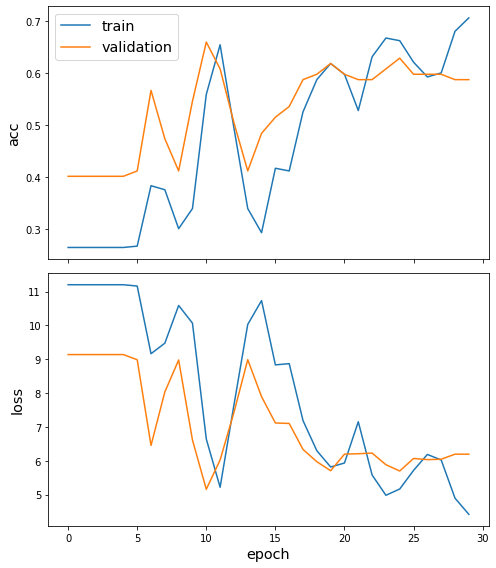

In [218]:
sg.utils.plot_history(history)

### Model Evaluation

#### Accuracy

In [219]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']

Test Set Metrics:
	loss: 6.1754
	acc: 0.5979


In [220]:
all_nodes = df_graph.index
all_gen = generator.flow(all_nodes)

In [221]:
all_predictions = model.predict(all_gen).squeeze()
#all_predictions = model.predict_generator(all_gen).squeeze()[..., np.newaxis].squeeze()
all_predictions.shape

(485,)

In [222]:
all_predictions_df = pd.DataFrame(all_predictions, index=df_graph.index)

In [223]:
#Let's extract the predictions for the test data only.
test_preds = all_predictions_df.loc[test_data.index, :]
print(test_preds.shape)
#The predictions are the probability of the true class.
test_preds.head()

(97, 1)


,0
CustomerID,
3001286,0.0
3002554,0.0
3001930,0.0
3000194,0.0
3001814,0.0


In [224]:
test_predictions = test_preds.values
test_predictions_class = ((test_predictions > 0.5) * 1).flatten()
test_df = pd.DataFrame(
    {
        "Predicted_score": test_predictions.flatten(),
        "Predicted_class": test_predictions_class,
        "True": test_targets[:, 0]
    }
)
roc_auc = metrics.roc_auc_score(test_df["True"].values, test_df["Predicted_score"].values)
print("The AUC on test set:\n", roc_auc)

The AUC on test set:
 0.5713969938107869


#### Confusion Matrix

In [225]:
pd.crosstab(test_df["True"], test_df["Predicted_class"])

Predicted_class,0,1
True,,
0,43,15
1,24,15


#### ROC curve

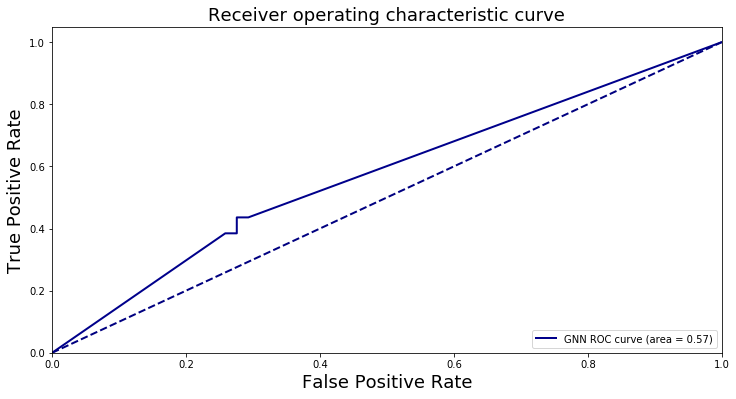

In [226]:
fpr, tpr, thresholds = metrics.roc_curve(
    test_df["True"], test_df["Predicted_score"], pos_label=1
)
plt.figure(figsize=(12, 6,))

lw = 2
plt.plot(
    fpr, tpr, color="darkblue", lw=lw, label="GNN ROC curve (area = %0.2f)" % roc_auc
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=18)
plt.ylabel("True Positive Rate", fontsize=18)
plt.title("Receiver operating characteristic curve", fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
model.layers

In [ ]:
if model_type == "graphsage":
    # For GraphSAGE, we are going to use the output activations
    # of the second GraphSAGE layer as the node embeddings
    # x_inp, prediction
    emb_model = Model(inputs=x_inp, outputs=model.layers[-4].output)
    emb = emb_model.predict_generator(generator=all_gen,)
elif model_type == "gcn":
    # For GCN, we are going to use the output activations of
    # the second GCN layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)
elif model_type == "gat":
    # For GAT, we are going to use the output activations of the
    # first Graph Attention layer as the node embeddings
    emb_model = Model(inputs=x_inp, outputs=model.layers[6].output)
    emb = emb_model.predict_generator(generator=all_gen)

In [ ]:
emb.shape
model.layers[8].output

In [ ]:
emb = emb.squeeze()

In [ ]:
emb.shape

In [ ]:
if model_type == "graphsage":
    emb_all_df = pd.DataFrame(emb, index=df_graph.index)
elif model_type == "gcn" or model_type == "gat":
    emb_all_df = pd.DataFrame(emb, index=G.nodes())

In [ ]:
#Select the embeddings for the test set. We are only going to visualise the test set embeddings.
emb_test = emb_all_df.loc[test_data.index, :]

In [ ]:
#Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label
X = emb_test
y = test_targets

In [ ]:
X.shape

In [ ]:
transform = TSNE  # or use PCA

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(X), index=test_data.index)
emb_transformed["label"] = y

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(14, 8,))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of embeddings for tweeter dataset".format(transform.__name__),
    fontsize=24,
)
plt.show()